<a href="https://colab.research.google.com/github/NITIN9694/TensorFlow-Learning/blob/main/11_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Fundamentals + MileStone Project 3 (Bit Predict)

##What is a time series problem?
Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

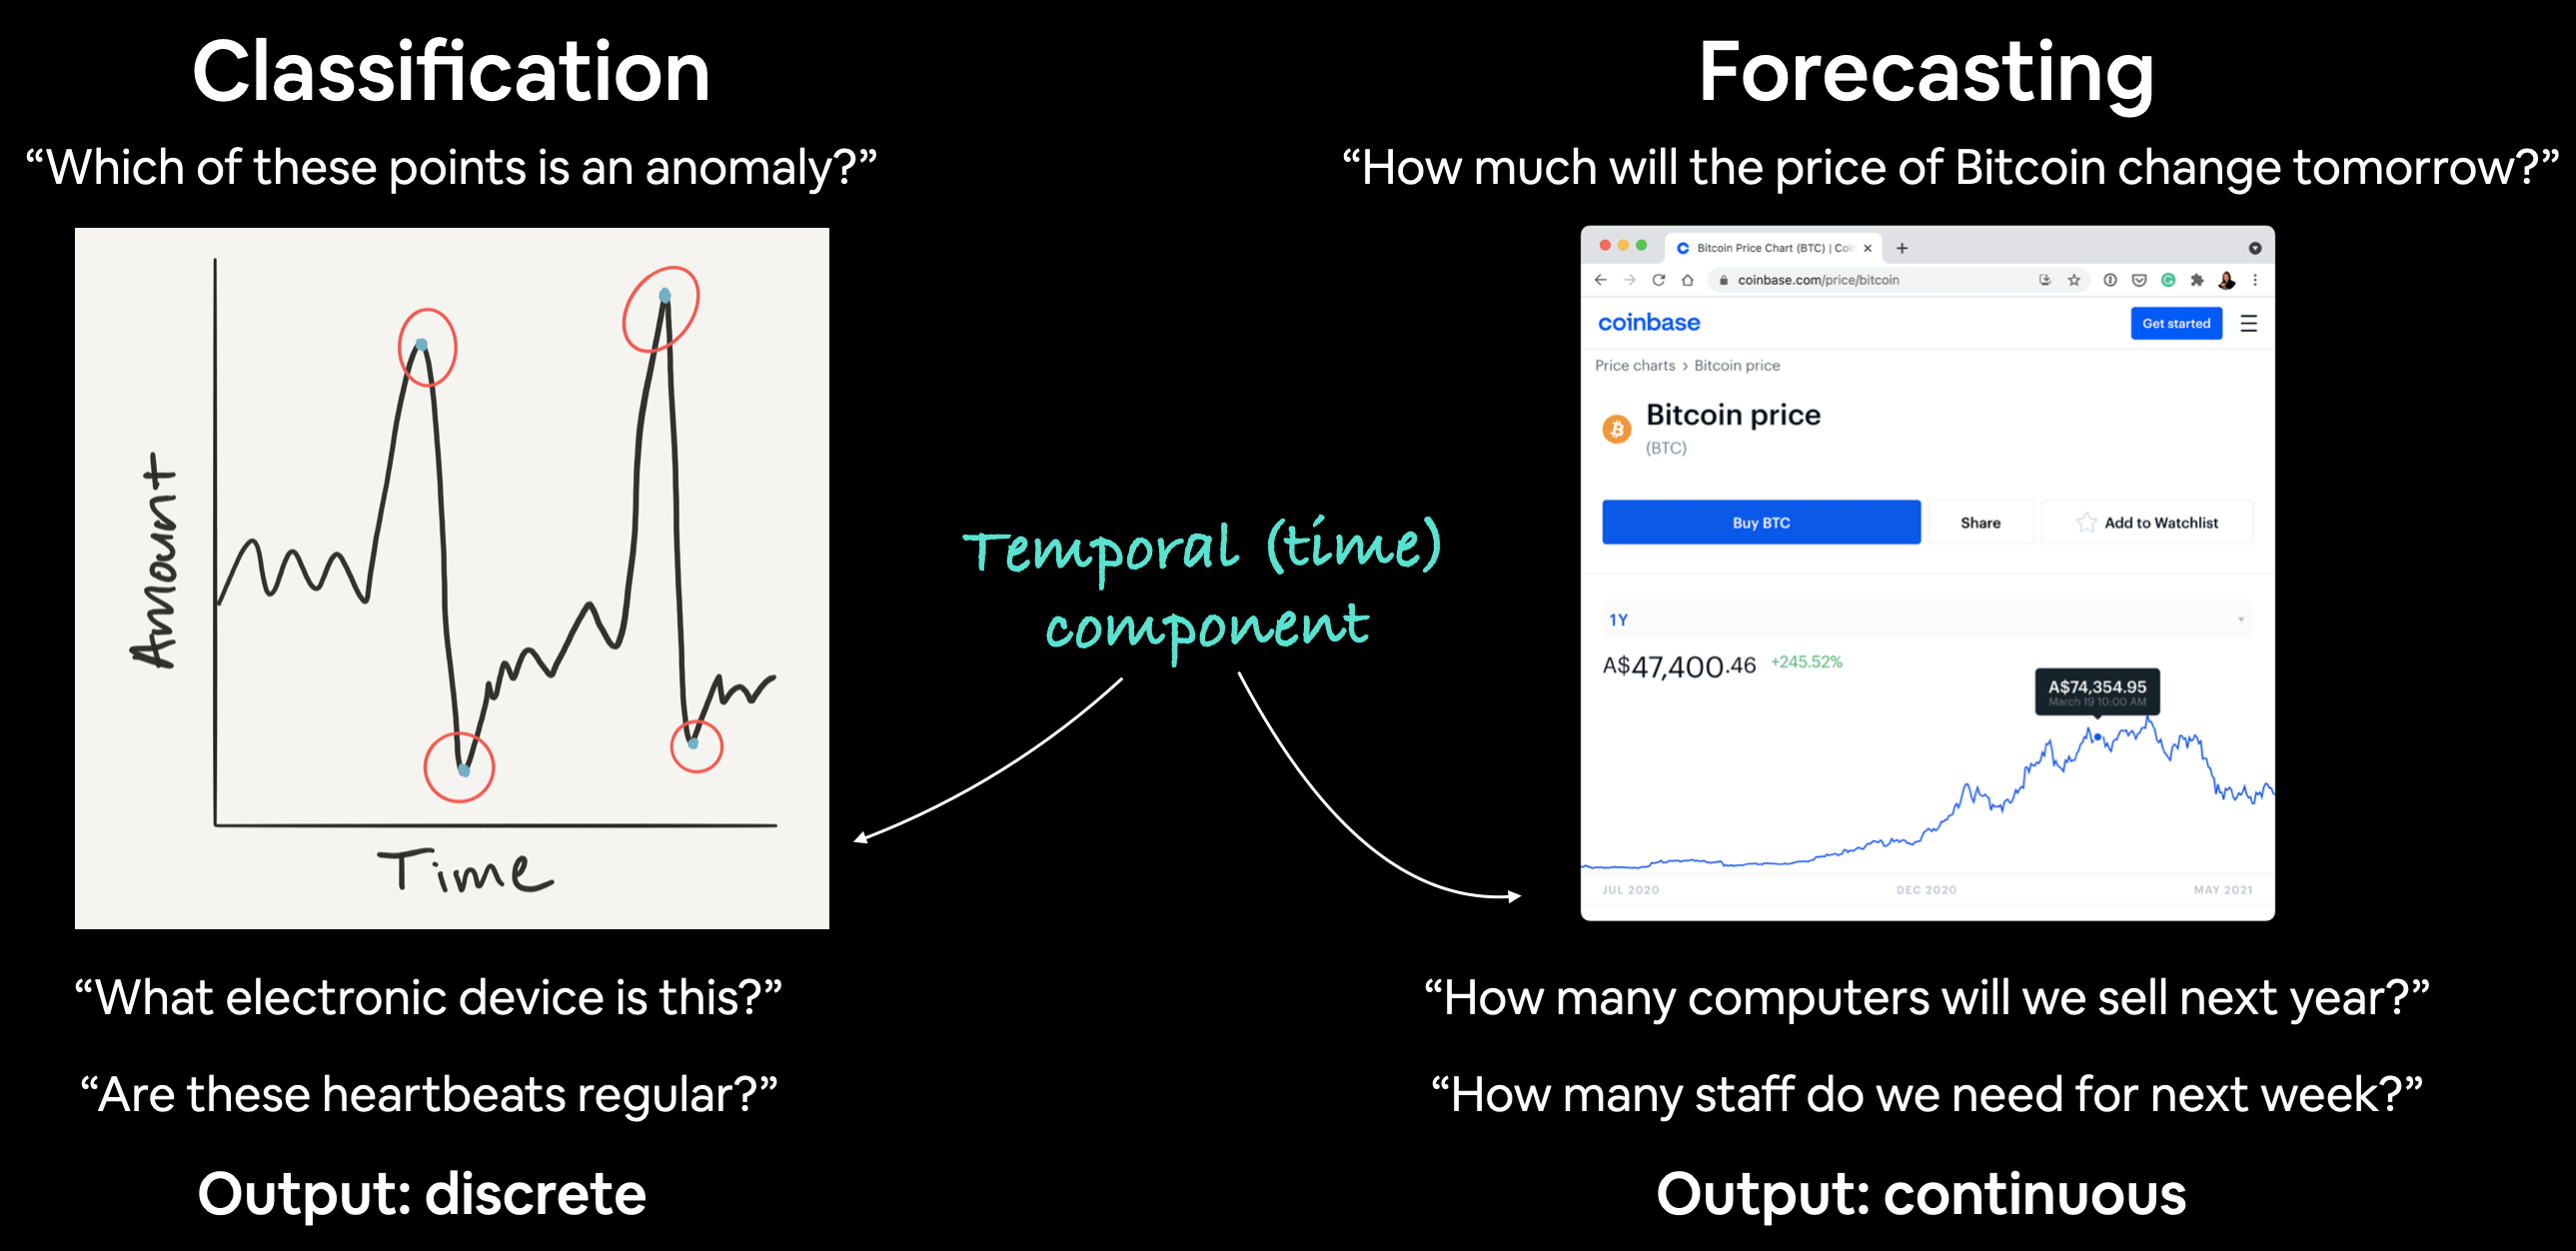

In [145]:
#check GPU
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [146]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2026-02-21 16:37:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.4’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2026-02-21 16:37:52 (7.07 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.4’ saved [178509/178509]



In [147]:
import pandas as pd

In [148]:
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",parse_dates=["Date"],
                 index_col =["Date"]
                 )
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [150]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


we collect the historical price of Bitcoin for the past 8 years but there onlu 2728 samples
Typically deep learning models usually like lots and lots data

🔑 Note: The frequency at which a time series value is collected is often referred to as **seasonality**. This is usually mesaured in number of samples per year. For example, collecting the price of Bitcoin once per day would result in a time series with a seasonality of 365. Time series data collected with different seasonality values often exhibit seasonal patterns (e.g. electricity demand behing higher in Summer months for air conditioning than Winter months).

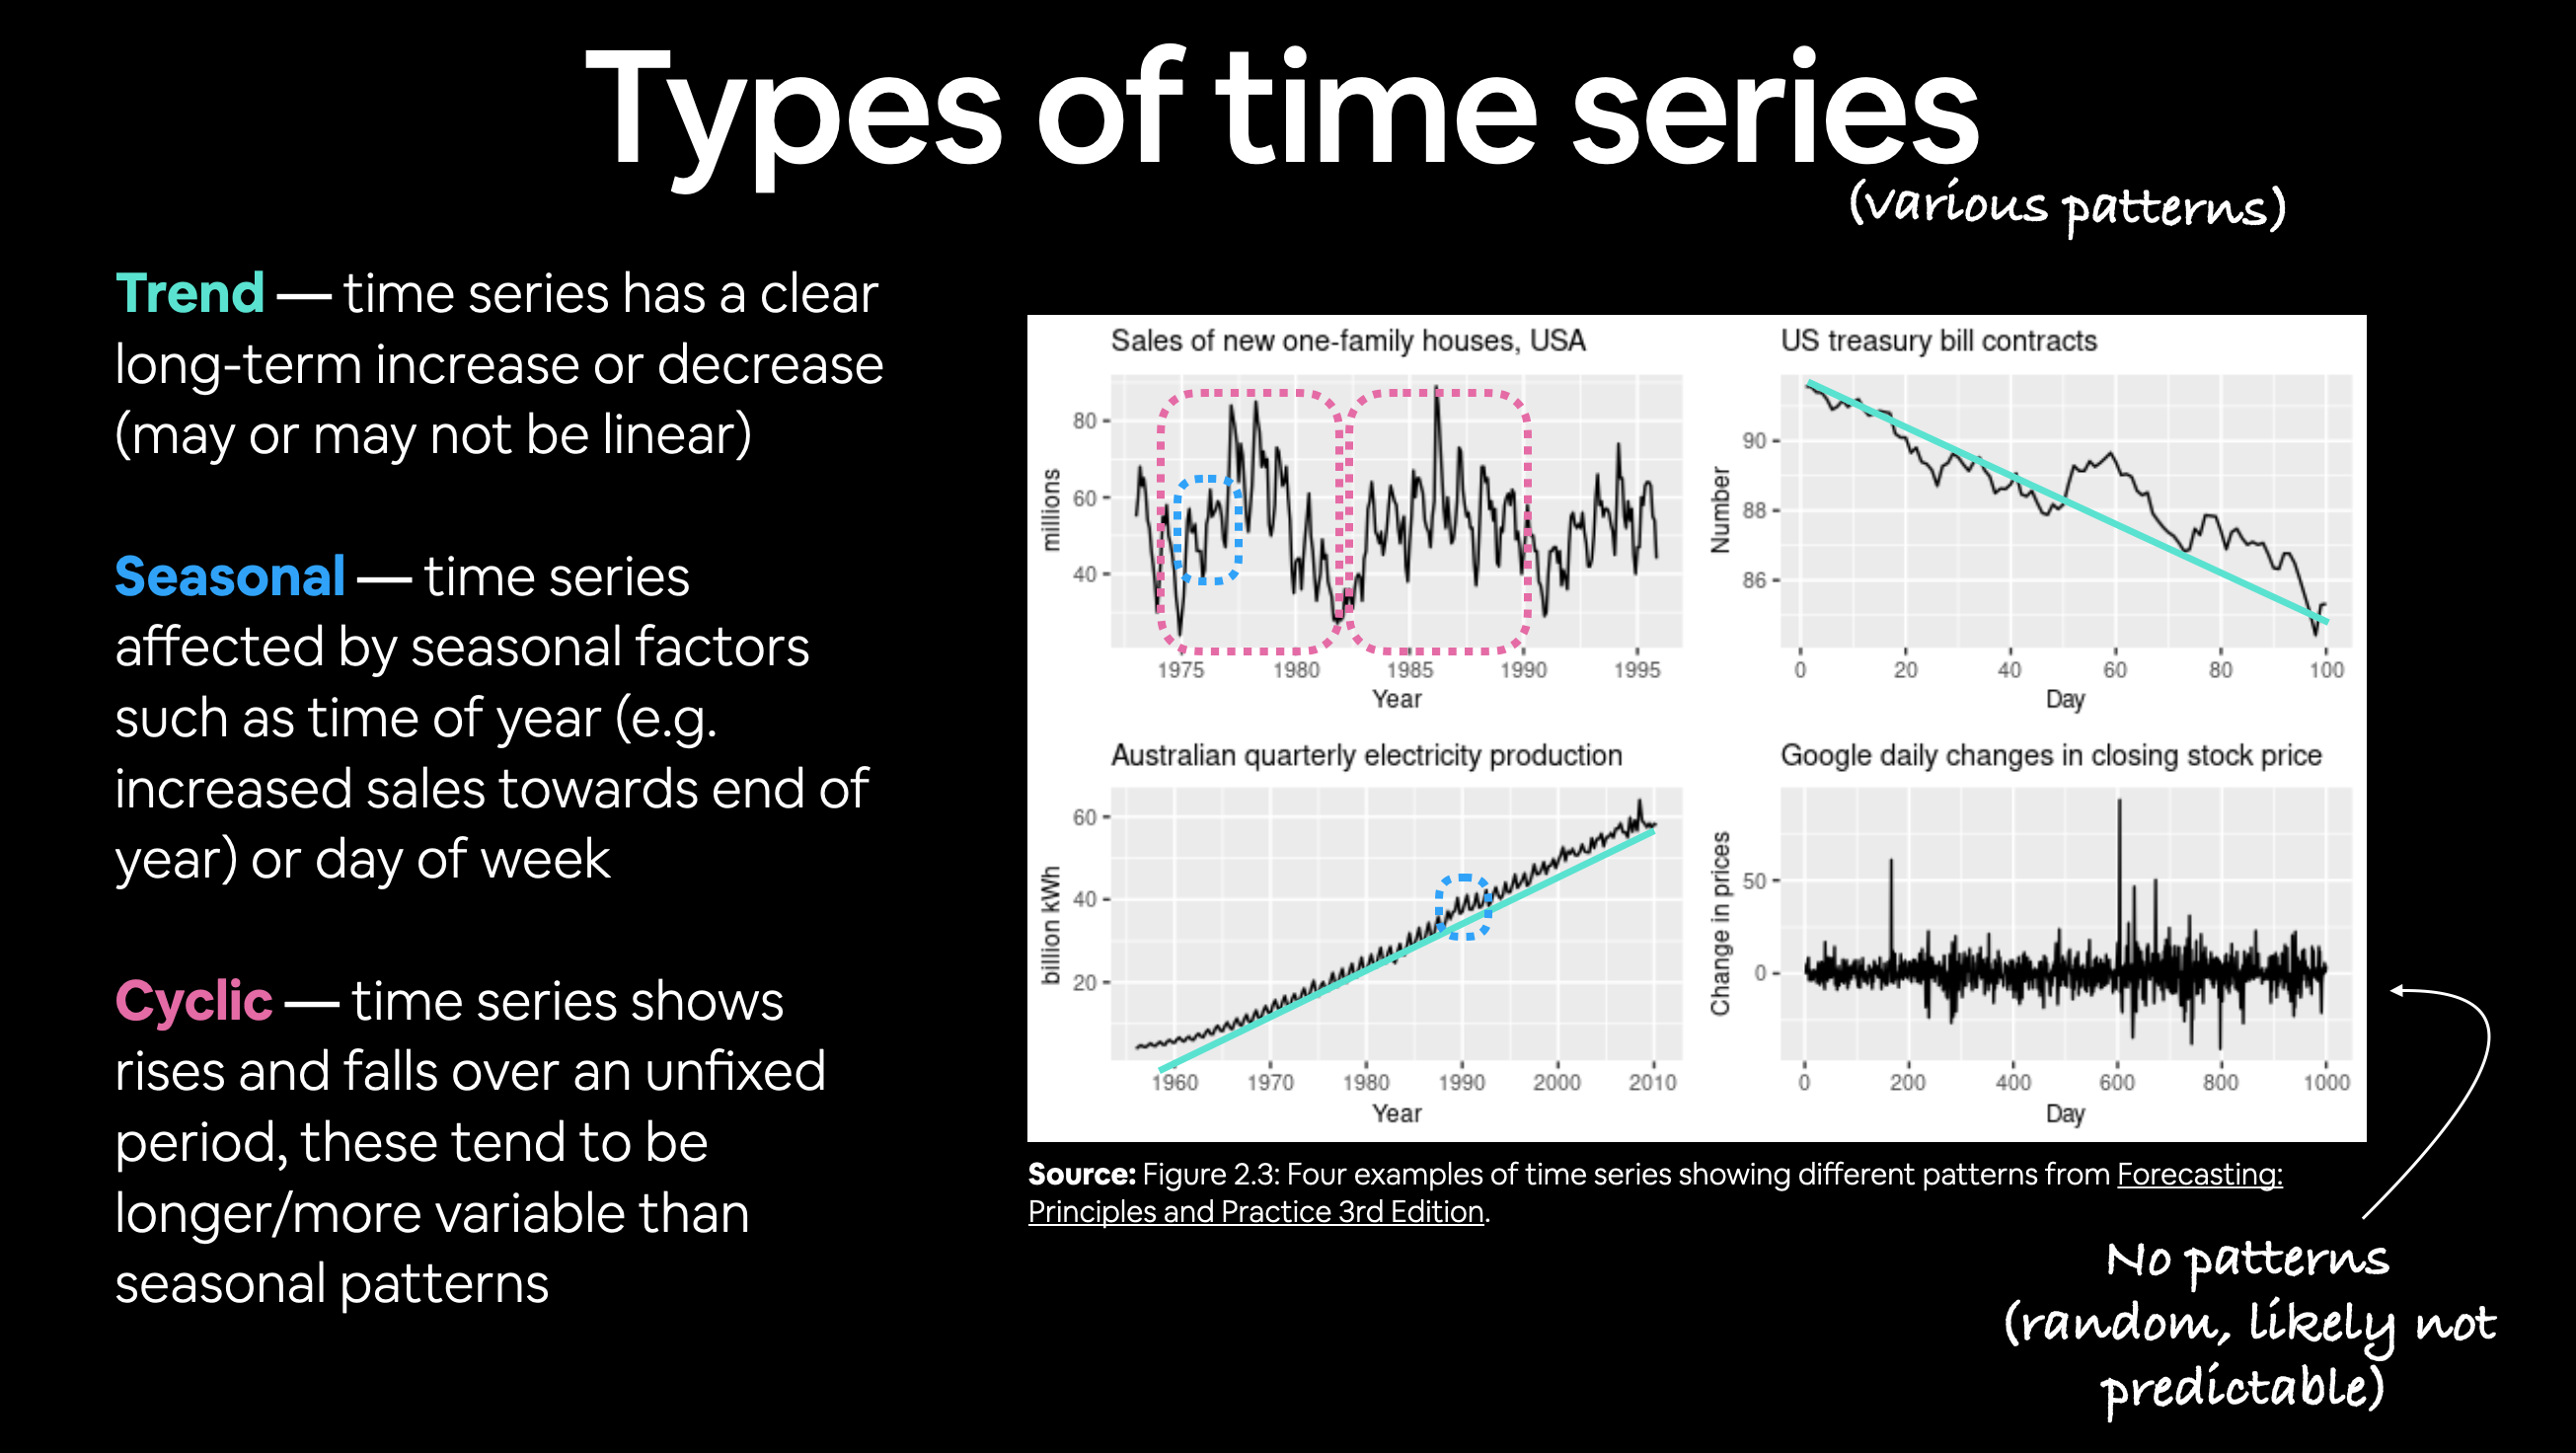

In [151]:
#Only want closing price each date
bitcoin_price =pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_price.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [152]:
import numpy as np
# Get bitcoin date array
timesteps = bitcoin_price.index.to_numpy()
prices = bitcoin_price["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

<Axes: xlabel='Date'>

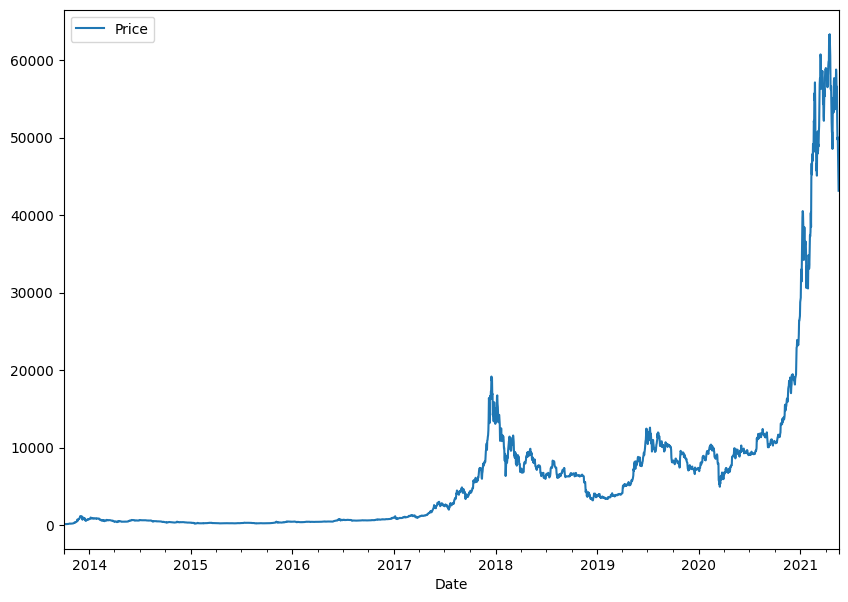

In [153]:
import matplotlib.pyplot as plt
bitcoin_price.plot(figsize=(10,7))

##Importing time series data with python csv module

In [154]:

# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

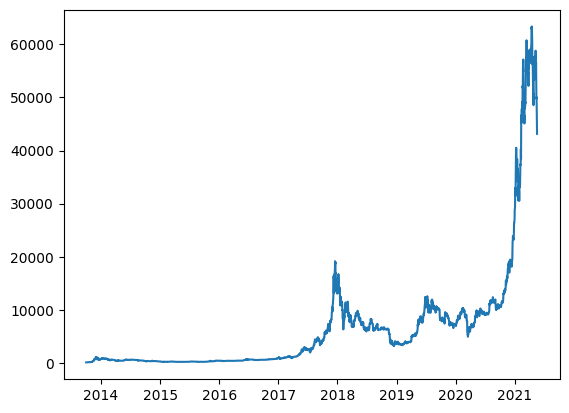

In [155]:
#plot from csv
import matplotlib.pyplot as plt
plt.plot(timesteps, btc_price)
plt.show()

##Create Train and Test for time series (the right way)
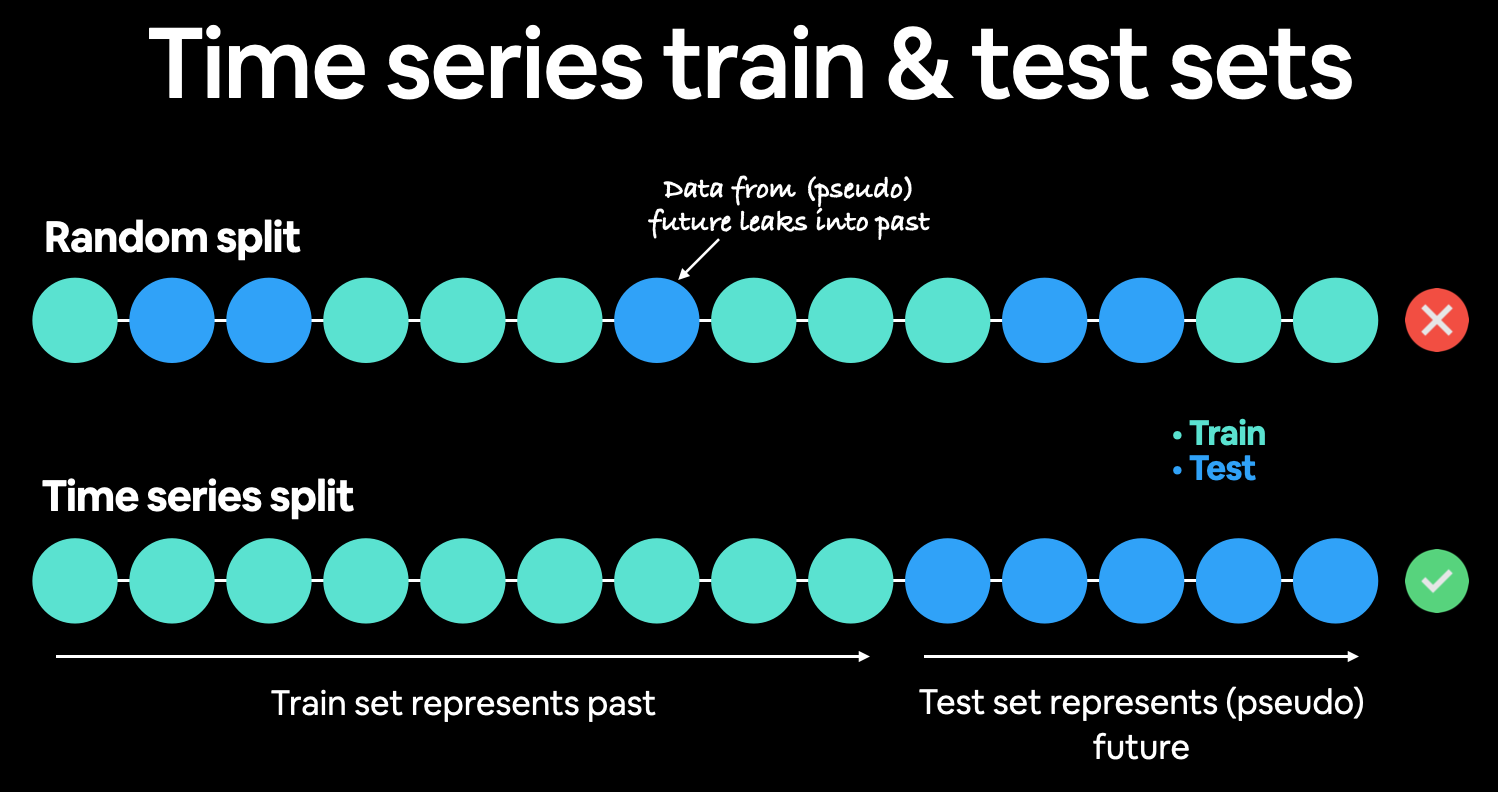

In [156]:
#create train and test split right way for data time series
split_size = int(0.8*len(btc_price))

#create train data split (every thing before the split)
X_train , y_train = timesteps[:split_size], btc_price[:split_size]

#create test data split
X_test, y_test = timesteps[split_size:],btc_price[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)




(2229, 558, 2229, 558)

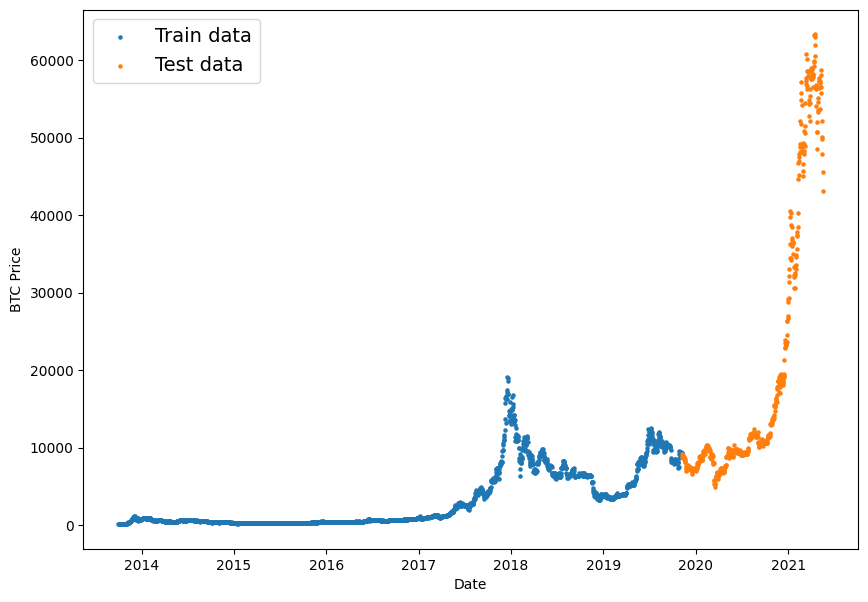

In [157]:

# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## create ploting fucation

In [158]:
#create a funcation a plot time data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values

  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

#Modelling Experiments
* **horizon** = number of timesteps to predict into future
* **window** = number of timesteps from past used to predict **horizon**

Model Number	Model Type	Horizon size	Window size	Extra data
* 0	Naïve model (baseline)	NA	NA	NA
* 1	Dense model	horizon = 1,window=7	NA
* 2	Same as 1	,horizone=1,window=	30	NA
* 3	Same as 1	,horizone=7,window=	30	NA
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

##Model 0 : Navis forcaset (Baseline)

forumula is:
$$\hat{y}_{t} = y_{t-1}$$

The Predication at timestep t (y=jat) is equal to the value at timestep t-1 )(previous timestep) - this is for a horizon for one

In [159]:
#create a nive forcast
navie_forcast = y_test[:-1]
navie_forcast[:10],navie_forcast[-10:]

([9226.4858208826,
  8794.3586445233,
  8798.0420546256,
  9081.1868784913,
  8711.5343391679,
  8760.8927181435,
  8749.520591019,
  8656.970922354,
  8500.6435581622,
  8469.2608988992],
 [57107.1206718864,
  58788.2096789273,
  58102.1914262342,
  55715.5466512869,
  56573.5554719043,
  52147.8211869823,
  49764.1320815975,
  50032.6931367648,
  47885.6252547166,
  45604.6157536131])

In [160]:
y_test[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43144.4712908603]

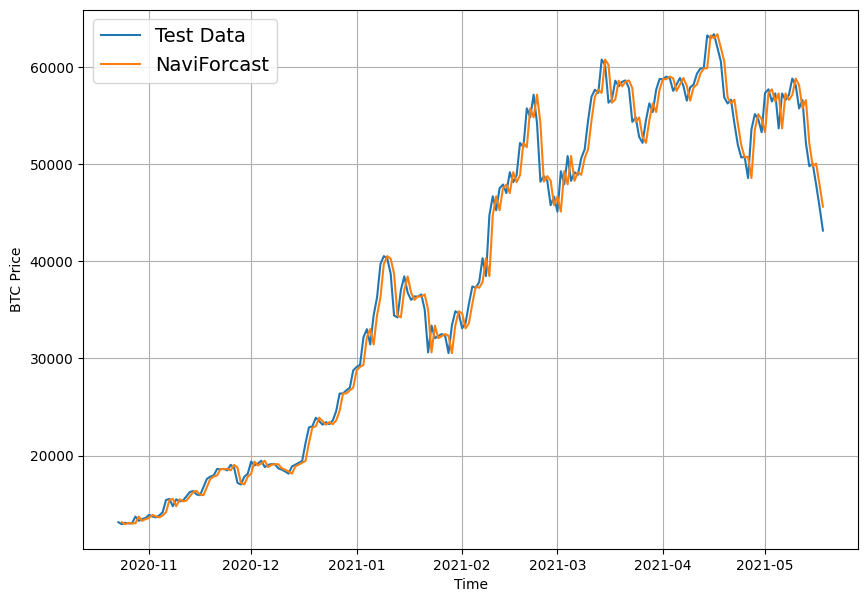

In [161]:
#plot navie forcast
plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_train,values=y_train,label="Train Data")
plot_time_series(timesteps=X_test,values=y_test,start=350,format="-",label="Test Data")
plot_time_series(timesteps=X_test[1:],values=navie_forcast,start=350,format="-",label="NaviForcast")



```
# This is formatted as code
```

##Evaluating a time series model

Let's look into some evaluation metrucs for time series forcasting.

what are we doing?

We're predicting a number, so that means we have form of **regression** problem.

A Few Common Regression Metrics
* MAE:Mean Absoulte Error
* MSE:Mean Squared Error
* RMSE: Root Mean Squared Error
*  MASE: Mean absolute scaled error

The main thing we're evaluating here is : **how do our model's forecasts(y_pred)
compare againt the actual values (y_true or ground truth values)?**





In [162]:
import tensorflow as tf


In [163]:
#MASE implements
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).

  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  #Find the MAE of naive forecastn
  mav_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))

  return mae/mav_naive_no_season


In [164]:
import tensorflow as tf
y_true_tf = tf.constant(y_test[1:], dtype=tf.float32)
y_pred_tf = tf.constant(navie_forcast, dtype=tf.float32)
mean_absolute_scaled_error(y_true=y_true_tf, y_pred=y_pred_tf).numpy()

np.float32(0.99957)

In [165]:
#create a funcation to take in model predicitons and truth values and return evaluation

def evalutate_preds(y_true,y_pred):

  #make sure float32 datatype
  y_true = tf.cast(y_true,dtype=tf.float32)
  y_pred = tf.cast(y_pred,dtype=tf.float32)

    # Calculate various evaluation metrics
  mae = tf.keras.losses.MAE(y_true,y_pred)
  mse = tf.keras.losses.MSE(y_true,y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.losses.MAPE(y_true,y_pred)
  mase = mean_absolute_scaled_error(y_true,y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":mape.numpy(),
          "mase":mase.numpy()
          }



In [166]:
navie_result = evalutate_preds(y_true=y_test[1:],y_pred=navie_forcast)
navie_result

{'mae': np.float32(567.9802),
 'mse': np.float32(1147547.0),
 'rmse': np.float32(1071.2362),
 'mape': np.float32(2.5165248),
 'mase': np.float32(0.99957)}




##Other Model you can use for baseline and for actual forecast


* Moving average	https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
* ARIMA (Autoregression Integrated Moving Average)	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* sktime (Scikit-Learn for time series)	https://github.com/alan-turing-institute/sktime
* TensorFlow Decision Forests (random forest, gradient boosting trees)	https://www.tensorflow.org/decision_forests
* Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)	https://github.com/facebookresearch/Kats
* LinkedIn Greykite (flexible, intuitive and fast forecasts)	https://github.com/linkedin/greykite

##Formate Data Part2: Windowing our dataset
why we do window?
we window our time series dataset to turn our data into a supervised learning problem

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

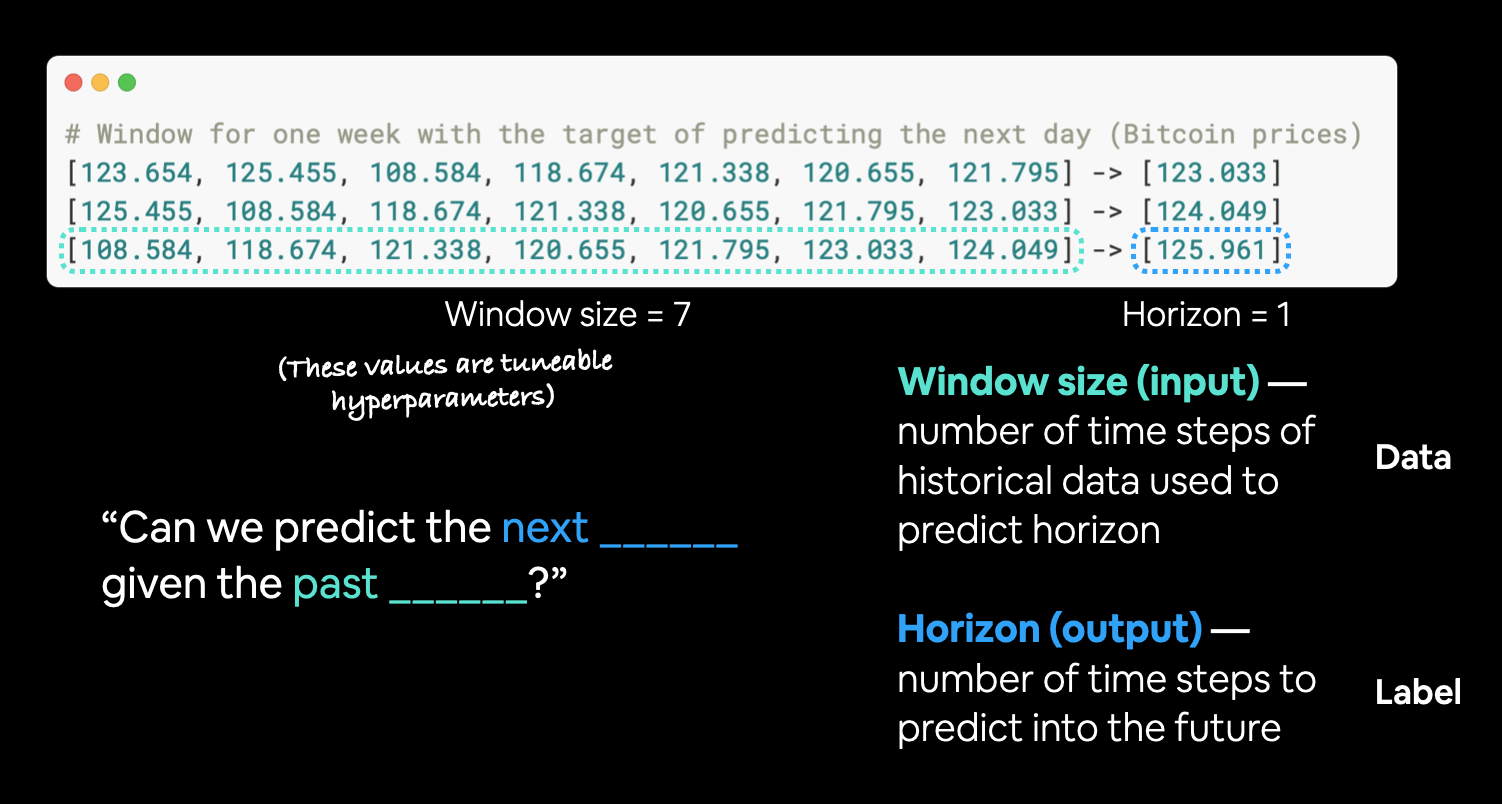

In [167]:
len(y_train)

2229

In [168]:
btc_price[:7]

[123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795]

In [169]:
#Lets setup global variable for window and horizon size
HORIZON = 1 #predict next 1 day
WINDOW_SIZE = 7 #use the past week of Bitcoun data to make the predication



In [170]:
#create funcation to label window data
def get_labelled_windows(x,horizon=HORIZON):
  """
  Creates labels for windowed dataset.
  E.g. if horizon is 1, labels will be the next day after given window, etc.
  """
  return x[:,:-horizon],x[:,-horizon:]

In [171]:
test_window,test_label = get_labelled_windows(tf.expand_dims(tf.range(8),axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


we fit a way to label our windowed data.
However this only works on a small scale.
We need a way to do the above acroos our entire time series.
We could do this with python for loops however for large time series, that be quite lsow,
To speed things up we'll leverage Numpy's array indexing

our funcation will:


1.   Create a window step of specific window size.
2.   Use Numpy indexing to create 2D array of multiple window steps of example:
```
[[0,1,2,3,4,5,6],
[1,2,3,4,5,6,7]
[2,3,4,5,6,7,8]]

```
3.  Use the 2D array of multiple window step (from 2.) to index on a target series (e.g the histroical price of Bitcoin)

4.  Use the `get_label_Windows()` funcation we created above to turn the window steps into windows with speicified horizon

In [172]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [173]:
full_windows, full_labels = make_windows(np.array(prices), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [174]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [175]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [176]:
def make_train_test_split(windows,labels,test_split=0.2):
  """
  split matching pairs of window and labels into train and test splits.

  """

  split_size = int(len(windows)*(1-test_split))
  train_window = windows[:split_size]
  train_labels = labels[:split_size]
  test_window =  windows[split_size:]
  train_window =  labels[split_size:]
  return train_window,train_labels,test_window,train_window

In [177]:
train_window,train_labels,test_window,train_window = make_train_test_split(full_windows,full_labels)

In [178]:
len(train_window),len(train_labels),len(test_window),len(train_window)

(556, 2224, 556, 556)